In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
import copy
import pandas
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

X = []
Y = []
for b in range(1, 5):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8') )
    Y.append( np.array(D[b'labels']))
print(len(X[0]) + len(X[1]) + len(X[2]) + len(X[3]))
for b in range(1, 5):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( np.flip(D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8'), 3) )
    Y.append( np.array(D[b'labels']))
for b in range(1, 5):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( np.flip(D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8'), 1) )
    Y.append( np.array(D[b'labels']))
for b in range(1, 5):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( np.flip(np.flip(D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8'), 1), 3) )
    Y.append( np.array(D[b'labels']))
X = np.vstack(X)
Y = np.hstack(Y).astype('int')

D = unpickle('./cifar-10-batches-py/test_batch')
Xt = D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8')
Yt = np.array(D[b'labels']).astype('int')
Lt = D[b'filenames']

40000


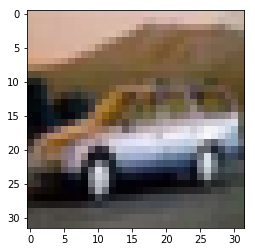

In [5]:
plt.imshow(np.rot90(np.flip(X[4+3*40000], 2).T, k=3))

In [6]:


class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self):
        super(Net, self).__init__()
        # batchnorm
        self.bn1 = nn.BatchNorm2d(3)
        # conv in 32x32x3, out 28x28x24
        self.c1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(5,5))
        # bn
        self.bn2 = nn.BatchNorm2d(24)
        # relu
        
        # max pooling  # in 28x28, out 14x14
        
        # conv in 14x14x24, out 10x10x48
        self.c2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(5,5))
        # bn
        self.bn3 = nn.BatchNorm2d(48)
        # relu
        
        # max pooling # in 10x10 out 5x5
        
        # flatten
        # dropout
        self.dout1 = nn.Dropout()
        
        # linear
        self.fc1 = nn.Linear(1200, 600)
        self.bn4 = nn.BatchNorm1d(600)
        # relu
        self.dout2 = nn.Dropout()
        self.fc2 = nn.Linear(600, 300)
        self.bn5 = nn.BatchNorm1d(300)
        # relu
        self.dout3 = nn.Dropout()
        self.fc3 = nn.Linear(300, 10)
        self.bn6 = nn.BatchNorm1d(10)
        # log softmax

    def forward(self, x):
        # TODO
        x = self.bn1(x)
        x = self.c1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(2,2))
        x = self.c2(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=(2,2))
        x = x.view(-1, 5*5*48)
        
        x = self.dout1(x)
        
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.dout2(x)
        
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.relu(x)
        
        x = self.dout3(x)
        
        x = self.fc3(x)
        x = self.bn6(x)
        x = F.relu(x)
        
        x = F.log_softmax(x)
        return x
   
net = Net().cuda()
print(net)

Net (
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (c1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True)
  (c2): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
  (dout1): Dropout (p = 0.5)
  (fc1): Linear (1200 -> 600)
  (bn4): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True)
  (dout2): Dropout (p = 0.5)
  (fc2): Linear (600 -> 300)
  (bn5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True)
  (dout3): Dropout (p = 0.5)
  (fc3): Linear (300 -> 10)
  (bn6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True)
)


In [7]:
import pickle
with open('./net18.pkl', 'rb') as f:
    result_nets = pickle.load(f)
net.load_state_dict(result_nets)

In [ ]:
loss_fn = torch.nn.NLLLoss().cuda()
loss_fn2 = torch.nn.NLLLoss().cuda()

learning_rate = 1e-2
iters = 100
batch_size = 10000
batch_size_2 = 1000
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_curve_train = []
loss_curve_test = []

for iter in log_progress(range(iters), name='Epochs'):
    Xperm = np.random.permutation(X.shape[0])
    loss_acc_train = 0
    for b in range(X.shape[0]//batch_size):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        x = Variable(torch.from_numpy(X[batch_idxs])).float().cuda()
        y = Variable(torch.from_numpy(Y[batch_idxs])).long().cuda()
                
        y_pred = net(x)

        loss = loss_fn(y_pred, y)
        loss_acc_train += loss.data[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    net.train(False)
    loss_acc_test = 0
    for b in range(Xt.shape[0]//batch_size_2):
        y_pred_test = net(Variable(torch.from_numpy(Xt[b*batch_size_2:(b+1)*batch_size_2])).float().cuda())
        loss_test = loss_fn2(y_pred_test, Variable(torch.from_numpy(Yt[b*batch_size_2:(b+1)*batch_size_2])).long().cuda()).data[0]
        loss_acc_test += loss_test
    net.train(True)
    #if iter > 25 and np.std(loss_curve_test[-21:])<0.009 and learning_rate == 1e-4:
    #    learning_rate /= 10
    #    print(learning_rate)
        
    print('Done epoch %s with train_loss %s and test_loss %s' % (iter, loss_acc_train, loss_acc_test))
    loss_curve_train.append(loss_acc_train)
    loss_curve_test.append(loss_acc_test)


#plt.plot(loss_curve_train)
plt.plot(np.arange(iters), loss_curve_train, 'b', np.arange(iters), loss_curve_test, 'g')

In [ ]:
plt.plot(np.arange(iters), loss_curve_test, 'g')

In [ ]:
import pickle

with open('./net19.pkl', 'wb') as f:
    pickle.dump(net.state_dict(), f)

In [9]:
net.train(False)
loss_fn = torch.nn.NLLLoss().cuda()
loss_acc_test = 0
batch_size_2 = 1000
for b in range(Xt.shape[0]//batch_size_2):
    y_pred_test = net(Variable(torch.from_numpy(Xt[b*batch_size_2:(b+1)*batch_size_2])).float().cuda())
    loss_test = loss_fn(y_pred_test, Variable(torch.from_numpy(Yt[b*batch_size_2:(b+1)*batch_size_2])).long().cuda()).data[0]
    loss_acc_test += loss_test
net.train(True)
print(loss_acc_test/10)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/THC/generic/THCStorage.cu:66

In [8]:
net.train(False)
y_pred = net(Variable(torch.from_numpy(Xt)).float().cuda())
loss_fn = torch.nn.NLLLoss().cuda()
print( loss_fn(y_pred, Variable(torch.from_numpy(Yt)).long().cuda()) )
net.train(True)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/THC/generic/THCStorage.cu:66

In [ ]:
d = pandas.DataFrame()
d['id'] = range(len(Yt))
yt = y_pred.data.cpu().numpy()
for i in range(10):
    d['c%s' % i] = np.exp(yt[:, i])

In [ ]:
d.to_csv('./res18_5692.csv', index=False)